| **Chapter**                   | 9:  Agent-based modeling                       |
| ----------------------------- |------------------------------------------------|
| **Computational Note**        | 9.x: Modeling anti-vaccine sentiment           |
| **Package prerequisites**     | [Mesa](https://mesa.readthedocs.io/en/latest/) |


# Modeling anti-vaccine sentiment

In previous examples, we have modeled cases where the likelihood of changing one's mind was different for everyone. In this Computational Note, we are looking at populations where a fraction of the population holds a position -- in this case, with respect to vaccination, but the model can be adapted to any other decision-making process -- that is fixed at a set value. We may consider the interaction of these individuals with the opinion dynamic process as fundamentally one-directional: their positions influence others, but others do not influence their position.

In [1]:
import numpy as np
import pandas as pd
from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.space import NetworkGrid
from mesa.datacollection import DataCollector
from mesa import batchrunner
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
import networkx as nx
import json
from scipy import stats
import enum


COLORS = {"S": "#2f4b7c",
          "E": "#ffa600",
          "I": "#f95d6a",
          "R": "#a05195",
          "D": "#003f5c",
          "C": "#ff7c43",
          "X": "#665191",
          "Y": "#d45087"}

In [2]:
%load_ext watermark
%watermark --iversions -v -a "Chris von Csefalvay" -gu "chrisvoncsefalvay"

Author: Chris von Csefalvay

Github username: chrisvoncsefalvay

Python implementation: CPython
Python version       : 3.10.2
IPython version      : 8.4.0

pandas    : 1.4.2
numpy     : 1.21.6
networkx  : 2.8.4
mesa      : 0.9.0
json      : 2.0.9
scipy     : 1.8.1
matplotlib: 3.5.2



In [3]:
class State(enum.IntEnum):
    SUSCEPTIBLE = 0
    INFECTED = 1
    RECOVERED = 2
    VACCINATED = 3
    DECEASED = 4

In [4]:
class Person(Agent):
    def __init__(self, uid, model, initial_attitude, tolerance, threshold, is_blocked):
        super().__init__(uid, model)
        
        # Naive start
        self.state = State.SUSCEPTIBLE
        self.attitude = initial_attitude
        self.threshold = threshold
        self.is_blocked = is_blocked
        self.tolerance = tolerance

    def contact_event(self):
        neighbourhood = self.model.grid.get_neighbors(self.pos, include_center=False)
        susceptible_neighbourhood = [agent for agent in self.model.grid.get_cell_list_contents(neighbourhood) 
                                                                            if agent.state is State.SUSCEPTIBLE]

        for neighbour in susceptible_neighbourhood:
            if self.state is State.INFECTED and np.random.rand() < self.model.beta:
                neighbour.state = State.INFECTED

    def adjust_attitude(self):
        neighbourhood = self.model.grid.get_neighbors(self.pos, include_center=False)
        qualified_neighbourhood = [agent for agent in self.model.grid.get_cell_list_contents(neighbourhood) 
                                   if (np.abs(agent.attitude - self.attitude) < self.tolerance 
                                   and agent.state is not State.DECEASED)]

        if len(qualified_neighbourhood) > 0:
            self.attitude = np.mean([neighbour.attitude for neighbour in qualified_neighbourhood])

    def status_update(self):        
        if self.attitude > self.threshold and self.state in [State.SUSCEPTIBLE, State.INFECTED, State.RECOVERED]:
            self.state = State.VACCINATED

        elif self.state == State.INFECTED:
            if np.random.rand() < 1/self.model.recovery_period:
                if np.random.rand() < self.model.CFR:
                    self.state = State.DECEASED
                else:
                    self.state = State.RECOVERED

        if np.random.rand() < self.model.base_mortality_rate:
            self.state = State.DECEASED


    def step(self):
        self.status_update()

        if self.state is State.INFECTED:
            self.contact_event()

        if self.state is not State.DECEASED and not self.is_blocked:
            self.adjust_attitude()    

In [5]:
class NetworkInfectiousDiseaseModel(Model):

    def __init__(self, 
                 nodes=5000, 
                 mean_degree=32,
                 recovery_period=12,
                 beta=0.01,
                 CFR=0.05,
                 attitude_distribution = stats.beta(3, 8),
                 tolerance_distribution = stats.beta(2, 20),
                 mean_threshold = 0.3,
                 stdev_threshold = 0.05,
                 base_mortality_rate=0.000125,
                 blocked_fraction=0.01,
                 I0=0.005):
                     
        self.N_agents = nodes
        self.recovery_period = recovery_period
        self.beta = beta
        self.CFR = CFR
        self.base_mortality_rate = base_mortality_rate

        self.graph = nx.erdos_renyi_graph(n=self.N_agents, p=mean_degree/self.N_agents)
        self.grid = NetworkGrid(self.graph)

        self.schedule = RandomActivation(self)
        self.running = True
        a = mean_threshold * ((mean_threshold * (1 - mean_threshold))/(stdev_threshold ** 2) - 1)
        b = a * ((1 - mean_threshold)/mean_threshold)

        threshold_distribution = stats.beta(a, b)

        for idx, node in enumerate(self.graph.nodes()):
            blocked_status = np.random.rand() < blocked_fraction 
                             
            agent = Person(uid=idx + 1, 
                           model=self, 
                           initial_attitude=0 if blocked_status else attitude_distribution.rvs() * 0.75, 
                           tolerance=tolerance_distribution.rvs(),
                           threshold=threshold_distribution.rvs(),
                           is_blocked=blocked_status)
            self.schedule.add(agent)
            self.grid.place_agent(agent, node)

            if np.random.rand() < I0:
                agent.state = State.INFECTED

        self.datacollector = DataCollector({"Vaccinated": lambda m: m.number_vaccinated(),
                                            "Infectious": lambda m: m.number_infectious()})

    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()

    def number_vaccinated(self):
        return np.sum([1 for i in self.schedule.agents if i.state is State.VACCINATED])
    
    def number_infectious(self):
        return np.sum([1 for i in self.schedule.agents if i.state is State.INFECTED])

In [6]:
br = batchrunner.FixedBatchRunner(NetworkInfectiousDiseaseModel,
                                  fixed_parameters={"nodes": 2500},
                                  parameters_list=[{"blocked_fraction": 0.0}, {"blocked_fraction": 0.1}, {"blocked_fraction": 0.2}],
                                  iterations=15,
                                  max_steps=125,
                                  model_reporters={"vals": lambda m: m.datacollector},
                                  display_progress=True)

In [7]:
br.run_all()

45it [22:49, 30.44s/it]


In [8]:
by_blocked_fraction = {}

for i in range(len(br.get_model_vars_dataframe().blocked_fraction)):
    if br.get_model_vars_dataframe().blocked_fraction[i] not in by_blocked_fraction.keys():
        by_blocked_fraction[br.get_model_vars_dataframe().blocked_fraction[i]] = []
    
    by_blocked_fraction[br.get_model_vars_dataframe().blocked_fraction[i]].append(
        br.get_model_vars_dataframe().vals[i].get_model_vars_dataframe()["Vaccinated"]
    )

In [9]:
infected_blocked_fraction = {}

for i in range(len(br.get_model_vars_dataframe().blocked_fraction)):
    if br.get_model_vars_dataframe().blocked_fraction[i] not in infected_blocked_fraction.keys():
        infected_blocked_fraction[br.get_model_vars_dataframe().blocked_fraction[i]] = []
    
    infected_blocked_fraction[br.get_model_vars_dataframe().blocked_fraction[i]].append(
        br.get_model_vars_dataframe().vals[i].get_model_vars_dataframe()["Infectious"]
    )

In [10]:
means = {}

for i in br.get_model_vars_dataframe().blocked_fraction.unique():
    mu = pd.concat([*(by_blocked_fraction[i])], axis=1).mean(axis=1)

    means[i] = mu


I_means = {}

for i in br.get_model_vars_dataframe().blocked_fraction.unique():
    mu = pd.concat([*(infected_blocked_fraction[i])], axis=1).mean(axis=1)

    I_means[i] = mu

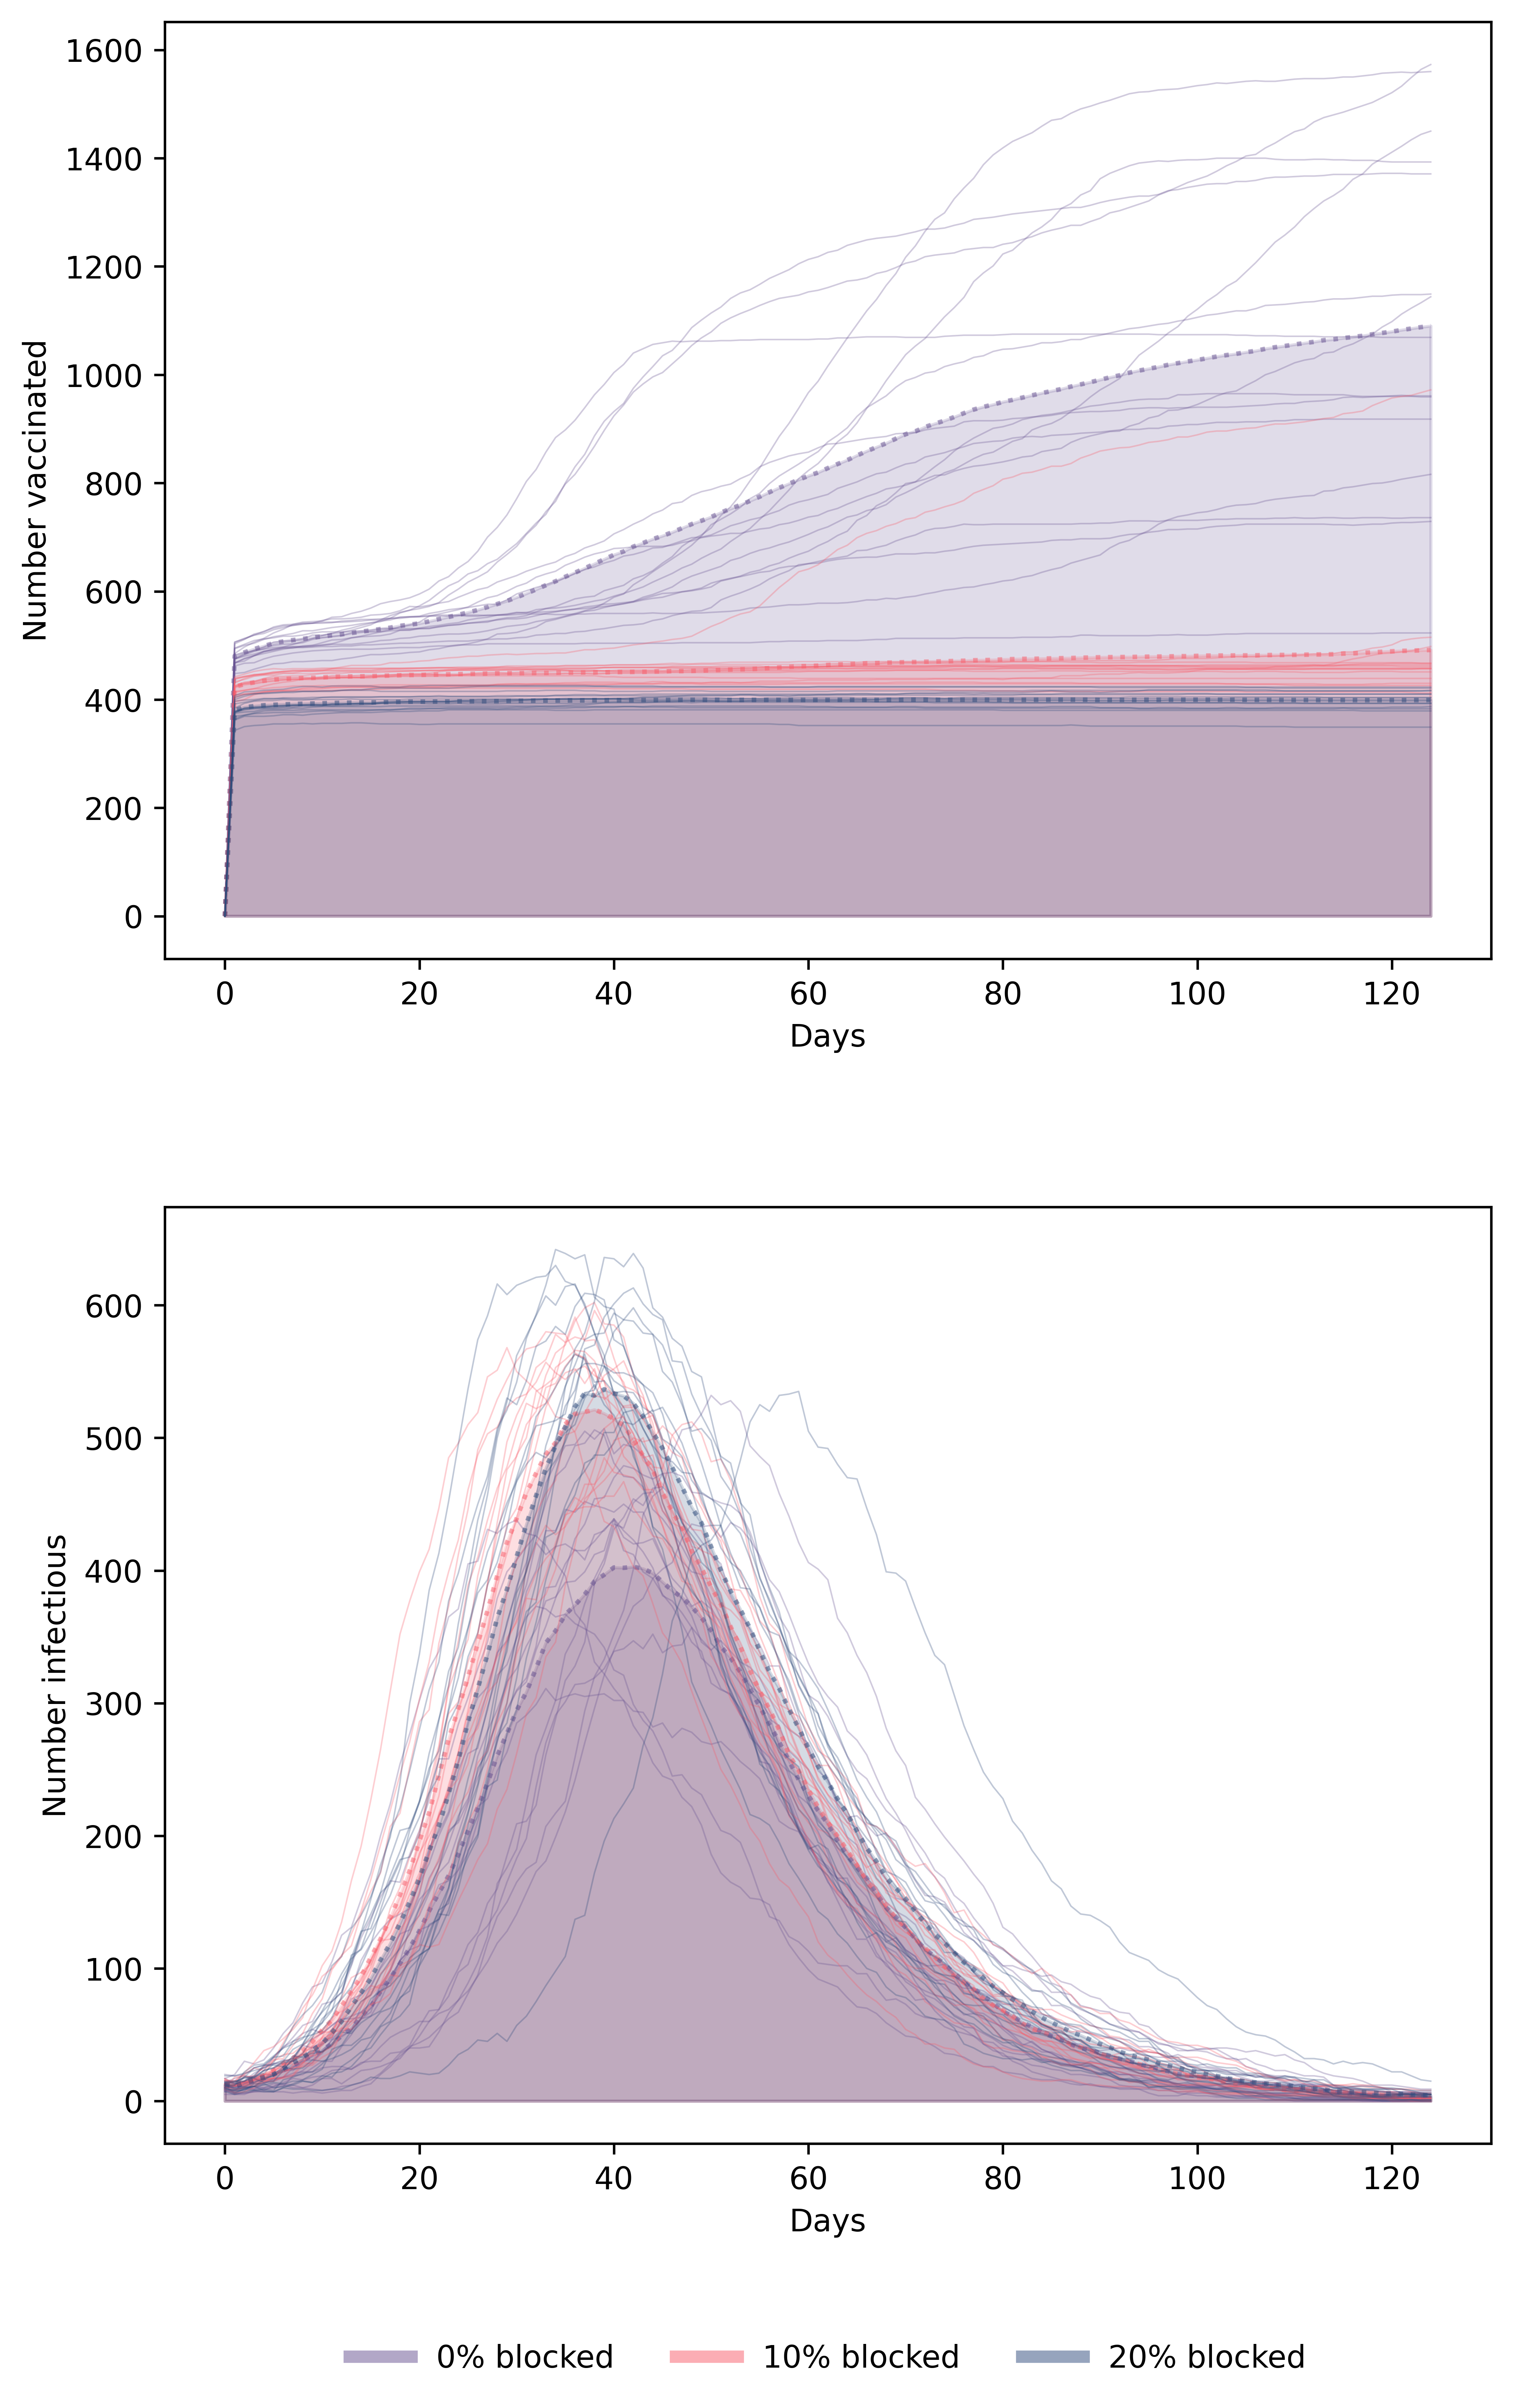

In [11]:
fig = plt.figure(facecolor="w", figsize=(8, 12), dpi=600)
ax = fig.add_subplot(211, axisbelow=True)

colour_cycle = ["X", "I", "S"]

for idx, thresh in enumerate(by_blocked_fraction.keys()):
    for ts in by_blocked_fraction[thresh]:
        ax.plot(ts, color=COLORS[colour_cycle[idx]], alpha=0.3, lw=0.5, label="")

    ax.plot(means[thresh], color=COLORS[colour_cycle[idx]], lw=1.5, alpha=0.5, linestyle=":")
    ax.fill_between(ts.index, means[thresh], 0, color=COLORS[colour_cycle[idx]], alpha=0.2)

ax.set_xlabel("Days")
ax.set_ylabel("Number vaccinated")


ax = fig.add_subplot(212, axisbelow=True)

for idx, thresh in enumerate(infected_blocked_fraction.keys()):
    for ts in infected_blocked_fraction[thresh]:
        ax.plot(ts, color=COLORS[colour_cycle[idx]], alpha=0.3, lw=0.5, label="")

    ax.plot(I_means[thresh], color=COLORS[colour_cycle[idx]], lw=1.5, alpha=0.5, linestyle=":")
    ax.fill_between(ts.index, I_means[thresh], 0, color=COLORS[colour_cycle[idx]], alpha=0.2)


legend_lines = [Line2D([0], [0], color=COLORS["X"], lw=4, alpha=0.5),
                Line2D([0], [0], color=COLORS["I"], lw=4, alpha=0.5),
                Line2D([0], [0], color=COLORS["S"], lw=4, alpha=0.5)]

ax.legend(legend_lines, ["0% blocked", "10% blocked", "20% blocked"], title="", bbox_to_anchor=(0.5, -0.275), loc="lower center", ncol=3, frameon=False)


ax.set_xlabel("Days")
ax.set_ylabel("Number infectious")

fig.tight_layout(pad=5.0)
plt.savefig("anti_vaccine_ABM.pdf")